# Chargement des données textuelles

In [122]:
import pandas as pd

def correct_text(text):
    text = re.sub(r'([a-zA-Z])([A-Z])', r'\1 \2', text) 
    text = re.sub(r'article(\d+)', r'article \1', text) 
    text = re.sub(r'([a-z])([A-Z])', r'\1 \2', text)  
    text = re.sub(r'([LR])\.\s*(\d[-\d]*)', r'\1.\2', text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(Des?|les?)articles", r"\1 articles", text)
    return text
    
df = pd.read_excel("./base_de_donnees.xlsx") 

df['Contenu'] = df['Contenu'].apply(correct_text)
texts_ = df['Contenu'].tolist()
df['Contexte'] = df['Source'] + '.x. ' + df['Contexte']
contexts = df['Contexte'].map(lambda x: x.replace('.x.', '.')).tolist()
print(df.shape)
print('*' * 120)
for source in df.Source.unique():
    print(f"Source {source}: {len(df[df['Source']==source])}")

print('*' * 120)
print(contexts[24].split('. '))
print(texts_[24])
df.to_excel('base_de_donnees_c.xlsx', index=False)

(4132, 3)
************************************************************************************************************************
Source Etablissement recevant des travailleurs: 299
Source Réglementation sécurité et incendie. Etablissement recevant du public: 44
Source Règlement de sécurité contre les risques d'incendie et de panique. Etablissements recevant du public: 1161
Source Code de la construction et de l'habitation: 2628
************************************************************************************************************************
['Etablissement recevant des travailleurs', "Obligations du maître d'ouvrage pour la conception des lieux de travail  (Articles R4211-1 à R4217-2)", 'Sécurité des lieux de travail (Articles R4214-1 à R4214-28)', 'Caractéristiques des bâtiments (Articles R4214-1 à R4214-8)', 'Article R4214-4', 'Créé par Décret n°2008-244 du 7 mars 2008 - art', '(V)', '']
Les surfaces des planchers, des murs et des plafonds sont conçues de manière à pouvoir êt

In [123]:
# df[df['Contenu'].str.contains('Desf')]['Contenu']

# GPU Actif

In [124]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

1.10.1+cu111
True


# Tokenizer & Embedding et application aux Textes et Contextes
- 4 modèles de tokenization/embedding utilisés: 'Flaubert', 'Camembert', 'Bert', 'DistilBert'

In [125]:
import torch
from transformers import DistilBertTokenizer, DistilBertModel
from transformers import CamembertTokenizer, CamembertModel
from transformers import BertTokenizer, BertModel
from transformers import FlaubertTokenizer, FlaubertModel

from tqdm import tqdm
import sys

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


models_names = ['flaubert/flaubert_base_cased', "camembert-base", "bert-base-multilingual-cased", 'distilbert-base-uncased']
models_suffix = ['Flaubert', 'Camembert', 'Bert', 'DistilBert']
model_index = 0
model_name = models_names[model_index]
model_suffix = models_suffix[model_index]

tokenizer = globals()[f'{model_suffix}Tokenizer'].from_pretrained(model_name)
model = globals()[f'{model_suffix}Model'].from_pretrained(model_name).to(device)

def get_embeddings(texts):
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).cpu()  


def process_embeddings(data):
    embeddings = []
    with tqdm(total=int(len(data))+1,file=sys.stdout) as prog_bar:
        for i in range(len(data)):
            embeddings.append(get_embeddings(data[i]))
            prog_bar.set_description('processed: %d' % (1 + i))
            prog_bar.update(1)            
    return torch.cat(embeddings, dim=0)

text_embeddings = process_embeddings(texts_)
print("Text embeddings done.")

context_embeddings = process_embeddings(contexts)
print("Context embeddings done.")


Using device: cuda


Some weights of the model checkpoint at flaubert/flaubert_base_cased were not used when initializing FlaubertModel: ['pred_layer.proj.weight', 'pred_layer.proj.bias']
- This IS expected if you are initializing FlaubertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing FlaubertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


processed: 4132: 100%|████████████████████████████████████████████████████████████▉| 4132/4133 [01:11<00:00, 58.12it/s]
Text embeddings done.
processed: 4132: 100%|████████████████████████████████████████████████████████████▉| 4132/4133 [00:59<00:00, 69.95it/s]
Context embeddings done.


# Aperçu de df

In [126]:
df

,Source,Contexte,Contenu
0,Etablissement recevant des travailleurs,Etablissement recevant des travailleurs.x. Obl...,"Les dispositions du présent titre déterminent,..."
1,Etablissement recevant des travailleurs,Etablissement recevant des travailleurs.x. Obl...,"Pour l application du présent titre, on entend..."
2,Etablissement recevant des travailleurs,Etablissement recevant des travailleurs.x. Obl...,Le maître d ouvrage élabore et transmet aux ut...
3,Etablissement recevant des travailleurs,Etablissement recevant des travailleurs.x. Obl...,Le dossier de maintenance des lieux de travail...
4,Etablissement recevant des travailleurs,Etablissement recevant des travailleurs.x. Obl...,Le dossier de maintenance des lieux de travail...
...,...,...,...
4127,Code de la construction et de l'habitation,Code de la construction et de l'habitation.x. ...,Pour leur application à Saint-Pierre-et-Miquel...
4128,Code de la construction et de l'habitation,Code de la construction et de l'habitation.x. ...,Pour leur application à Saint-Pierre-et-Miquel...
4129,Code de la construction et de l'habitation,Code de la construction et de l'habitation.x. ...,Les articles D. 842-15 à D. 842-18 ne sont pas...
4130,Code de la construction et de l'habitation,Code de la construction et de l'habitation.x. ...,"Les articles R.842-14, R.843-2 à R.843-8 ne..."


# Recherche du texte le plus proche

In [127]:
from tqdm import tqdm
import sys


user_query = "Je dois installer des dispositifs de désenfumage. A quoi dois je faire attention"
user_query = "Je dois faire des modification dans un établissement recevant le public. Par qui l'autorisation est elle délivrée"
query_embeddings = get_embeddings(user_query)

text_embeddings = text_embeddings.to(device)
context_embeddings = context_embeddings.to(device)
query_embeddings = query_embeddings.to(device)

similarities = torch.nn.functional.cosine_similarity(query_embeddings, text_embeddings, dim=1)

most_similar_index = torch.argmax(similarities).item()

top_k = 3
top_k_indices = torch.argsort(similarities, descending=True)[:top_k]
print(f"User query: {user_query}\n\n")

for idx in top_k_indices:
    idx = idx.item() 
    text = df.loc[idx, 'Contenu']
    context = df.loc[idx, 'Contexte']
    source = df.loc[idx, 'Source']
    similarity_coeff = similarities[idx]
    print('-' * 120)
    print(f"Cosine Similarity: {similarity_coeff:.4f}\n\nSource plus proche:{df.loc[idx, 'Source']}\n\n Contexte: {df.loc[idx, 'Contexte']}")
    print(f"\nTexte: {df.loc[idx, 'Contenu']}")

User query: Je dois faire des modification dans un établissement recevant le public. Par qui l'autorisation est elle délivrée


------------------------------------------------------------------------------------------------------------------------
Cosine Similarity: 0.5724

Source plus proche:Code de la construction et de l'habitation

 Contexte: Code de la construction et de l'habitation.x. Article R641-19.x. Dispositions permettant de faire face à des difficultés particulières de logement..x. Mesures tendant à favoriser la construction d'habitations..x. Sociétés coopératives de construction..x. Agrément des contrôleurs techniques.x. Diagnostic portant sur les déchets issus de rénovations et de démolitions.x. Modifié par Décret n°99-340 du 29 avril 1999 - art. 1 () JORF 5 mai 1999.x. 

Texte: Le délai supplémentaire prévu àl article L.641-1, alinéa 4, ne peut être accordé au bénéficiaire de l attribution d office lorsque le propriétaire notifie qu il entre dans une des catégories pré

# Finetuning espace d'embedding

In [128]:
df.Source.unique()

array(['Etablissement recevant des travailleurs',
       'Réglementation sécurité et incendie. Etablissement recevant du public',
       "Règlement de sécurité contre les risques d'incendie et de panique. Etablissements recevant du public",
       "Code de la construction et de l'habitation"], dtype=object)

In [129]:
import random
import numpy as np


df_1 = df[(df['Source']!="Code de la construction et de l'habitation") & (df['Source']!="Etablissement recevant des travailleurs")].copy()
df_2 = df[df['Source']=="Code de la construction et de l'habitation"].copy()
df_3 = df[df['Source']=="Etablissement recevant des travailleurs"].copy()


df_1.reset_index(inplace=True, drop='True')
df_2.reset_index(inplace=True, drop='True')

def calculate_similarity(context_1, context_2):
    context_1_list = context_1.split('.')[:-1]
    context_2_list = context_2.split('.')[:-1]
    common_levels =  len(list(set(context_1_list).intersection(context_2_list)))
    max_levels = np.min([len(context_1_list), len(context_2_list)])
    ratio = common_levels/max_levels
    return -2 * np.exp(-ratio/0.2) + 1

def get_index_list(df_, n):
    lst_idx = []
    for _ in range(n):
        a, b = random.randint(0, len(df_)-1), random.randint(0, len(df_)-1)
        while b == a: b = random.randint(0, len(df_)-1)
        lst_idx.append((a, b))
    return lst_idx

list_1_indexes = get_index_list(df_=df_1, n=4000)
liste_1 = [{"sentence1": df_1.loc[i, 'Contenu'], "sentence2": df_1.loc[j, 'Contenu'], 
            'label': calculate_similarity(df_1.loc[i, 'Contexte'], df_1.loc[j, 'Contexte'])} for i, j in list_1_indexes]

list_2_indexes = get_index_list(df_=df_2, n=4000)
liste_2 = [{"sentence1": df_2.loc[i, 'Contenu'], "sentence2": df_2.loc[j, 'Contenu'], 
            'label': calculate_similarity(df_2.loc[i, 'Contexte'], df_2.loc[i, 'Contexte'])} for i, j in list_2_indexes]

data = [*[{"sentence1": df_1.loc[i, 'Contexte'], "sentence2": df_1.loc[i, 'Contenu'], 'label': 1} for i in range(len(df_1))],
        *[{"sentence1": df_2.loc[i, 'Contexte'], "sentence2": df_2.loc[i, 'Contenu'], 'label': 1} for i in range(len(df_2))],
        # *[{"sentence1": df_1.loc[i, 'Contexte'], "sentence2": df_2.loc[i, 'Contenu'], 'label': -1} for i in range(min(len(df_1), len(df_2)))],
        # *[{"sentence1": df_2.loc[i, 'Contexte'], "sentence2": df_1.loc[i, 'Contenu'], 'label': -1} for i in range(min(len(df_1), len(df_2)))],
        # *[{"sentence1": df_1.loc[i, 'Contexte'], "sentence2": df_2.loc[i, 'Contexte'], 'label': -1} for i in range(min(len(df_1), len(df_2)))],
        # *[{"sentence1": df_2.loc[i, 'Contenu'], "sentence2": df_1.loc[i, 'Contenu'], 'label': -1} for i in range(min(len(df_1), len(df_2)))],
        *liste_1, *liste_2]

print(f'Dataset composé de: {len(df_1) + len(df_2)} de relations positives (1) entre contexte et contenu')
print(f'Dataset composé de: {len(liste_1) + len(liste_2)} de relations entre -1 et 1 entre contenus différents')

Dataset composé de: 3833 de relations positives (1) entre contexte et contenu
Dataset composé de: 8000 de relations entre -1 et 1 entre contenus différents


# Construction de la bade de donnees avec label contrastif

In [130]:
from torch.utils.data import Dataset, DataLoader

class ContrastiveDataset(Dataset):
    def __init__(self, data, tokenizer, max_len=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data[index]
        tokens = self.tokenizer(row['sentence1'], row['sentence2'], truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt')
        label = torch.tensor(row['label'], dtype=torch.float)
        return tokens, label

tokenizer = globals()[f'{model_suffix}Tokenizer'].from_pretrained(model_name)
dataset = ContrastiveDataset(data, tokenizer)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


# Définition du model: XBert + couche de projection

In [131]:
import torch.nn as nn

class ContrastiveModel(nn.Module):
    def __init__(self, model_name=model_name, embedding_dim=text_embeddings.shape[1]):
        super(ContrastiveModel, self).__init__()
        self.bert = globals()[f'{model_suffix}Model'].from_pretrained(model_name)
        self.projection = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, embedding_dim),
            nn.ReLU(),
            nn.Linear(embedding_dim, embedding_dim)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state[:, 0] 
        return self.projection(embeddings)

model_C = ContrastiveModel()
model_C.to(device)

Some weights of the model checkpoint at flaubert/flaubert_base_cased were not used when initializing FlaubertModel: ['pred_layer.proj.weight', 'pred_layer.proj.bias']
- This IS expected if you are initializing FlaubertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing FlaubertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


ContrastiveModel(
  (bert): FlaubertModel(
    (position_embeddings): Embedding(512, 768)
    (embeddings): Embedding(68729, 768, padding_idx=2)
    (layer_norm_emb): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (attentions): ModuleList(
      (0): MultiHeadAttention(
        (q_lin): Linear(in_features=768, out_features=768, bias=True)
        (k_lin): Linear(in_features=768, out_features=768, bias=True)
        (v_lin): Linear(in_features=768, out_features=768, bias=True)
        (out_lin): Linear(in_features=768, out_features=768, bias=True)
      )
      (1): MultiHeadAttention(
        (q_lin): Linear(in_features=768, out_features=768, bias=True)
        (k_lin): Linear(in_features=768, out_features=768, bias=True)
        (v_lin): Linear(in_features=768, out_features=768, bias=True)
        (out_lin): Linear(in_features=768, out_features=768, bias=True)
      )
      (2): MultiHeadAttention(
        (q_lin): Linear(in_features=768, out_features=768, bias=True)
      

# Définition de la fonction perte: MSE

In [132]:
import torch.nn.functional as F

def contrastive_loss(embeddings1, embeddings2, labels, margin=1.0):
    cosine_sim = F.cosine_similarity(embeddings1, embeddings2)
    loss = torch.mean((cosine_sim - labels) ** 2)
    return loss

# Entrainement

In [145]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=1e-9)
n_epochs = 1
for epoch in range(n_epochs):
    model_C.train()
    for batch in dataloader:
        tokens, labels = batch
        input_ids = tokens['input_ids'].squeeze(1).to(device)
        attention_mask = tokens['attention_mask'].squeeze(1).to(device)
        labels = labels.to(device)

        embeddings1 = model_C(input_ids, attention_mask)
        embeddings2 = model_C(input_ids, attention_mask)

        loss = contrastive_loss(embeddings1, embeddings2, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1} Loss: {loss.item()}")

Epoch 1 Loss: 0.025497661903500557


# Construction matrice de similarité nouveaux embedding

In [146]:
def embed_text(query, model, tokenizer, device):
    model_C.eval()
    tokens = tokenizer(query, padding=True, truncation=True, max_length=512, return_tensors="pt").to(device)
    with torch.no_grad():
        output = model_C(tokens['input_ids'], tokens['attention_mask'])
    embeddings = output[0]
    if len(embeddings.shape) == 1:
        return embeddings  
    else:
        return embeddings.mean(dim=1)  
 

def process_embeddings(data, model_, tokenizer, device):
    embeddings = []
    with tqdm(total=len(data), file=sys.stdout) as prog_bar:
        for i in range(len(data)):
            embeddings.append(embed_text(data[i], model_, tokenizer, device))
            prog_bar.set_description('Processed: %d' % (i + 1))
            prog_bar.update(1)
    return torch.stack(embeddings)  

query_embeddings = embed_text(user_query, model, tokenizer, device)
query_embeddings = query_embeddings.to(device)

text_embeddings_finetuned = process_embeddings(texts_, model_C, tokenizer, device)
print("Text embeddings done.")

context_embeddings_finetuned = process_embeddings(contexts, model_C, tokenizer, device)
print("Context embeddings done.")


similarities = torch.nn.functional.cosine_similarity(query_embeddings, text_embeddings_finetuned, dim=1)
print("Cosine similarities calculated.")

Processed: 4132: 100%|█████████████████████████████████████████████████████████████| 4132/4132 [01:19<00:00, 52.19it/s]
Text embeddings done.
Processed: 4132: 100%|█████████████████████████████████████████████████████████████| 4132/4132 [01:06<00:00, 61.88it/s]
Context embeddings done.
Cosine similarities calculated.


In [147]:
top_k = 3
top_k_indices = torch.argsort(similarities, descending=True)[:top_k]
print(f"User query: {user_query}\n\n")

for idx in top_k_indices:
    idx = idx.item() 
    text = df.loc[idx, 'Contenu']
    context = df.loc[idx, 'Contexte']
    source = df.loc[idx, 'Source']
    similarity_coeff = similarities[idx]
    print('-' * 120)
    print(f"Cosine Similarity: {similarity_coeff:.4f}\n\nSource plus proche:{df.loc[idx, 'Source']}\n\n Contexte: {df.loc[idx, 'Contexte']}")
    print(f"\nTexte: {df.loc[idx, 'Contenu']}")

User query: Je dois faire des modification dans un établissement recevant le public. Par qui l'autorisation est elle délivrée


------------------------------------------------------------------------------------------------------------------------
Cosine Similarity: 0.6273

Source plus proche:Etablissement recevant des travailleurs

 Contexte: Etablissement recevant des travailleurs.x. Obligations de l'employeur pour l'utilisation des lieux de travail  (Articles R4221-1 à R4228-37).x. Aération, assainissement (Articles R4222-1 à R4222-26).x. Locaux à pollution non spécifique (Articles R4222-4 à R4222-9).x. Article R4222-9.x. Créé par Décret n°2008-244 du 7 mars 2008 - art. (V).x. 

Texte: Il est interdit d envoyer après recyclage dans un local à pollution non spécifique l air pollué d un local à pollution spécifique.
------------------------------------------------------------------------------------------------------------------------
Cosine Similarity: 0.6243

Source plus proche:Cod

# Evaluation des transformations de l'embedding

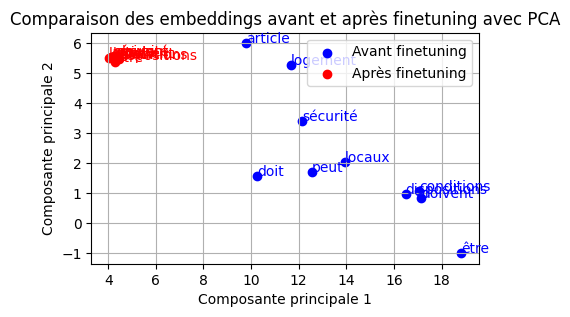

In [148]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
import re

    
stop_words = set(stopwords.words('french'))


def embed_text_(query, model, tokenizer, device):
    model_C.eval()
    tokens = tokenizer(query, padding=True, truncation=True, max_length=512, return_tensors="pt").to(device)
    with torch.no_grad():
        output = model_C(tokens['input_ids'], tokens['attention_mask'])
    return output[0].squeeze(0)

list_mots = [mot for mot in re.split(r"[^\w']+", ' '.join(texts_).lower()) if (mot.lower() not in stop_words) & (len(mot)>3)]
    
comptage_mots = Counter(list_mots)
mots_plus_frequents = [mot for mot, _ in comptage_mots.most_common(10)]


pca = PCA(n_components=2)
embeddings_avant_2d = pca.fit_transform(text_embeddings.cpu().numpy())
embeddings_apres_2d = pca.transform(text_embeddings_finetuned.cpu().numpy())

mots_plus_frequents_embeddings_avant = []
mots_plus_frequents_embeddings_apres = []
for mot in mots_plus_frequents:
    mot_embedding_avant = get_embeddings(mot)
    mot_embedding_apres = embed_text_(mot, model_C, tokenizer, device)
    
    mots_plus_frequents_embeddings_avant.append(mot_embedding_avant)
    mots_plus_frequents_embeddings_apres.append(mot_embedding_apres)

mots_plus_frequents_embeddings_avant = torch.cat(mots_plus_frequents_embeddings_avant, dim=0)
mots_plus_frequents_embeddings_apres = torch.cat(mots_plus_frequents_embeddings_apres, dim=0)

embeddings_plus_frequent_avant_2d = pca.transform(mots_plus_frequents_embeddings_avant.cpu().numpy())
embeddings_plus_frequent_apres_2d = pca.transform(mots_plus_frequents_embeddings_apres.cpu().numpy().reshape(10, 768))

plt.figure(figsize=(5, 3))
plt.scatter(embeddings_plus_frequent_avant_2d[:, 0], embeddings_plus_frequent_avant_2d[:, 1], color='blue', label='Avant finetuning')
plt.scatter(embeddings_plus_frequent_apres_2d[:, 0], embeddings_plus_frequent_apres_2d[:, 1], color='red', label='Après finetuning')

for i, mot in enumerate(mots_plus_frequents):
    plt.annotate(mot, (embeddings_plus_frequent_avant_2d[i, 0], embeddings_plus_frequent_avant_2d[i, 1]), color='blue')
    plt.annotate(mot, (embeddings_plus_frequent_apres_2d[i, 0], embeddings_plus_frequent_apres_2d[i, 1]), color='red')

plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.title('Comparaison des embeddings avant et après finetuning avec PCA')
plt.legend()
plt.grid()
plt.show()

In [137]:
recherche = 'ouvrage'
print(set([item for item in list_mots if recherche in item]))

{'ouvrages', 'ouvrage'}


In [138]:
# comptage_mots

In [139]:
print(len(mots_plus_frequents_embeddings_apres))
type(mots_plus_frequents_embeddings_apres[0])

7680


torch.Tensor

# Enregistrement du modèle

In [140]:
from transformers import AutoConfig

config = AutoConfig.from_pretrained(model_name)
config.vocab_size = tokenizer.vocab_size
config.save_pretrained('./finetuned/model')

tokenizer.save_pretrained('./finetuned/model')
torch.save(model.state_dict(), './finetuned/contrastive_model.pth')

df_embeddings = pd.DataFrame({
    'Text': [*texts_, *contexts],
    'Embedding': [embedding.tolist() for embedding in (*text_embeddings.to('cpu'), *context_embeddings.to('cpu'))], 
})
df_embeddings.to_csv('./finetuned/embedding_matrix.csv', index=False)

# Mise en place du RAG:
- Utilisation de faiss alimenté par l'embedding réentrainé pour le retriver
- Utilisation de AutoModelForSeq2SeqLM "t5-base" por le generateur

In [141]:
from transformers import AutoTokenizer, AutoModel
import faiss
import ast

tokenizer = AutoTokenizer.from_pretrained('./finetuned/model')
model_loaded = ContrastiveModel()  
model_loaded.load_state_dict(torch.load('./finetuned/contrastive_model.pth'), strict=False)
model_loaded.eval().to('cuda' if torch.cuda.is_available() else 'cpu')


df_embeddings = pd.read_csv('./finetuned/embedding_matrix.csv')
df_embeddings['Embedding'] = df_embeddings['Embedding'].apply(ast.literal_eval)
texts = df_embeddings['Text'].tolist()
embeddings = torch.tensor(df_embeddings['Embedding'].tolist())


index = faiss.IndexFlatL2(embeddings.shape[1]) 
index.add(embeddings.numpy()) 

print(f"Index construit avec {index.ntotal} documents.")

Some weights of the model checkpoint at flaubert/flaubert_base_cased were not used when initializing FlaubertModel: ['pred_layer.proj.weight', 'pred_layer.proj.bias']
- This IS expected if you are initializing FlaubertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing FlaubertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x00000295C491C310>>
Traceback (most recent call last):
  File "C:\Users\Nedved\anaconda3\envs\gpu_pytorch\lib\site-packages\ipykernel\ipkernel.py", line 790, in _clean_thread_parent_frames
    active_threads = {thread.ident for thread in threadin

Index construit avec 8264 documents.


In [142]:
from transformers import AutoModelForSeq2SeqLM

def retrieve(query, model, tokenizer, index, texts, top_k=5):
    query_embedding = embed_text(query, model, tokenizer, device).unsqueeze(0)
    distances, indices = index.search(query_embedding.to('cpu').numpy(), top_k)
    fais_results = [{"text": texts[i], "distance": distances[0][j]} for j, i in enumerate(indices[0])]
    return fais_results

def generate_answer(context, query, generator, tokenizer):
    input_text = f"Context: {context} Query: {query}"
    input_ids = tokenizer.encode(input_text, return_tensors='pt', max_length=512, truncation=True)
    outputs = generator.generate(input_ids, max_length=128, num_beams=5, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

generator = AutoModelForSeq2SeqLM.from_pretrained("t5-base").to('cpu')

def rag_pipeline(user_query, model, tokenizer, index, texts, generator):
    retrieved = retrieve(user_query, model, tokenizer, index, texts, es, index_name, top_k=5)
    context = " ".join([item['text'] for item in retrieved])

    response = generate_answer(context, user_query, generator, tokenizer)
    return response

response = rag_pipeline(user_query, model, tokenizer, index, texts, generator)
print("Réponse générée :\n", response)


TypeError: retrieve() got multiple values for argument 'top_k'

In [ ]:
print("Longueur des input_ids:", len(input_ids[0]))

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(input_ids[0].tolist())
print("Tokens:", tokens)
print("Indices:", input_ids)

In [ ]:
# from langchain.vectorstores import FAISS
# from langchain.embeddings import HuggingFaceEmbeddings
# from langchain.chains import RAGChain, LLMChain
# from langchain.prompts import PromptTemplate
# from langchain.llms import HuggingFacePipeline

# class FAISS_Retriever:
#     def __init__(self, index, texts):
#         self.index = index
#         self.texts = texts

#     def retrieve(self, query, top_k=3):
#         inputs = tokenizer(query, return_tensors="pt", truncation=True, padding=True, max_length=512)
#         with torch.no_grad():
#             query_embedding = generator(**inputs).last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

#         distances, indices = self.index.search(np.array([query_embedding]), top_k)
#         results = [self.texts[i] for i in indices[0]]
#         return results

# retriever = FAISS_Retriever(index, texts)

# template = """
# Voici le contexte de la demande:  {context}
# Dans ce cadre, réponds à cette question: {query}
# """

# prompt = PromptTemplate(input_variables=["context", "query"], template=template)
# llm = HuggingFacePipeline(pipeline=generator)
# chain = LLMChain(llm=llm, prompt=prompt)

# retrieved_docs = retriever.retrieve(user_query)
# context = " ".join(retrieved_docs)
# response = chain.run({"context": context, "query": query})

# print(response)